In [1]:
import pandas as pd
data = pd.read_csv('Diabetes_Data.csv')

In [2]:
data["Gender"] = data["Gender"].map({"男生": 1, "女生": 0})
data

,Age,Weight,BloodSugar,Gender,Diabetes
0,25,119,130.8,1,1
1,66,102,128.1,0,1
2,59,65,103.9,1,0
3,46,117,94.8,0,0
4,45,79,57.8,1,0
...,...,...,...,...,...
395,72,63,97.1,0,0
396,22,117,156.7,0,1
397,31,76,119.0,1,0
398,36,65,96.3,0,1


In [3]:
from sklearn.model_selection import train_test_split
x = data[["Age", "Weight", "BloodSugar", "Gender"]]
y = data["Diabetes"]

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=87)
x_train = x_train.to_numpy()
x_test = x_test.to_numpy()
y_train = y_train.to_numpy()
y_test = y_test.to_numpy()

In [4]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler.fit(x_train)
x_train = scaler.transform(x_train)
x_test = scaler.transform(x_test)

In [5]:
import torch
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

In [6]:
x_train = torch.from_numpy(x_train)
x_test = torch.from_numpy(x_test)
y_train = torch.from_numpy(y_train)
y_test = torch.from_numpy(y_test)

x_train = x_train.to(device)
x_test = x_test.to(device)
y_train = y_train.to(device)
y_test = y_test.to(device)

In [7]:
from torch import nn

class LogisticRegressionModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear_layer = nn.Linear(in_features=4, out_features=1, dtype=torch.float64)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        return self.sigmoid(self.linear_layer(x))

In [8]:
torch.manual_seed(87)
model = LogisticRegressionModel()
model = model.to(device)
model, model.state_dict()

(LogisticRegressionModel(
   (linear_layer): Linear(in_features=4, out_features=1, bias=True)
   (sigmoid): Sigmoid()
 ),
 OrderedDict([('linear_layer.weight',
               tensor([[-0.4710,  0.1380, -0.1459, -0.1397]], dtype=torch.float64)),
              ('linear_layer.bias', tensor([-0.4544], dtype=torch.float64))]))

In [9]:
x_train.dtype, model.linear_layer.weight.dtype, model.linear_layer.bias.dtype

(torch.float64, torch.float64, torch.float64)

In [10]:
y_train = y_train.reshape(-1, 1)#-1代表自動調整
y_test = y_test.reshape(-1, 1)
y_train = y_train.type(torch.double)
y_test = y_test.type(torch.double)

# 要記得先進行資料轉換，以免發生錯誤

In [11]:
cost_function = nn.BCELoss()
y_pred = model(x_train)
cost = cost_function(y_pred, y_train)
print(model.state_dict())
print(cost)
print('\n')

optimizer = torch.optim.SGD(params=model.parameters(), lr=0.01)
optimizer.zero_grad()
cost.backward()
optimizer.step()

y_pred = model(x_train)
cost = cost_function(y_pred, y_train)
print(model.state_dict())
print(cost)

OrderedDict([('linear_layer.weight', tensor([[-0.4710,  0.1380, -0.1459, -0.1397]], dtype=torch.float64)), ('linear_layer.bias', tensor([-0.4544], dtype=torch.float64))])
tensor(0.7056, dtype=torch.float64, grad_fn=<BinaryCrossEntropyBackward0>)


OrderedDict([('linear_layer.weight', tensor([[-0.4697,  0.1394, -0.1422, -0.1394]], dtype=torch.float64)), ('linear_layer.bias', tensor([-0.4552], dtype=torch.float64))])
tensor(0.7038, dtype=torch.float64, grad_fn=<BinaryCrossEntropyBackward0>)


In [12]:
epochs = 10000

train_cost_hist = []
test_cost_hist = []
train_acc_hist = []
test_acc_hist = []

for epoch in range(epochs + 1):

    model.train()

    y_pred = model(x_train)

    train_cost = cost_function(y_pred, y_train)
    train_cost_hist.append(train_cost.detach().numpy())

    train_acc = (torch.round(y_pred)==y_train).sum() / len(y_train) * 100
    #torch.round做四捨五入
    train_acc_hist.append(train_acc.detach().numpy())

    optimizer.zero_grad()
    train_cost.backward()
    optimizer.step()
    
    model.eval()
    with torch.inference_mode():
        test_pred = model(x_test)
        test_cost = cost_function(test_pred, y_test)
        test_cost_hist.append(test_cost.numpy())

        test_acc = (torch.round(test_pred)==y_test).sum() / len(y_test) * 100
        test_acc_hist.append(test_acc.numpy())

    if epoch%1000==0:
        # print(f"Epoch: {epoch:5}, Train Cost: {train_cost: .4e}, Test Cost: {test_cost: .4e}")
        print(f"Epoch: {epoch:5}, Train Acc: {train_acc:7}%, Test Acc: {test_acc:5}%")

Epoch:     0, Train Acc: 54.6875%, Test Acc: 51.25%
Epoch:  1000, Train Acc: 88.4375%, Test Acc:  85.0%
Epoch:  2000, Train Acc:   88.75%, Test Acc:  85.0%
Epoch:  3000, Train Acc:    90.0%, Test Acc:  85.0%
Epoch:  4000, Train Acc: 89.6875%, Test Acc:  85.0%
Epoch:  5000, Train Acc: 89.6875%, Test Acc: 86.25%
Epoch:  6000, Train Acc: 89.6875%, Test Acc: 88.75%
Epoch:  7000, Train Acc: 89.6875%, Test Acc: 88.75%
Epoch:  8000, Train Acc:  89.375%, Test Acc: 88.75%
Epoch:  9000, Train Acc:  89.375%, Test Acc:  90.0%
Epoch: 10000, Train Acc: 89.0625%, Test Acc:  90.0%


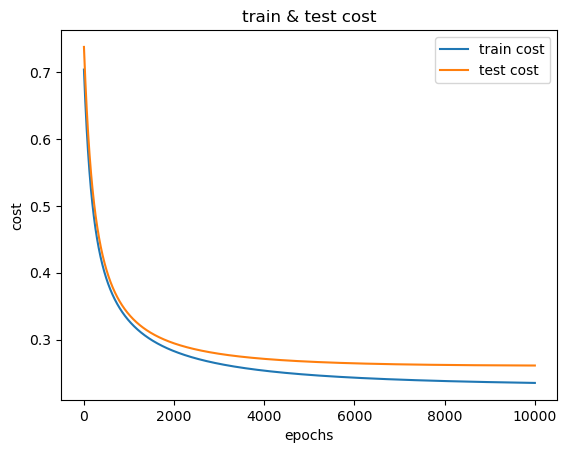

In [13]:
import matplotlib.pyplot as plt
plt.plot(range(0, epochs + 1), train_cost_hist, label="train cost")
plt.plot(range(0, epochs + 1), test_cost_hist, label="test cost")
plt.title("train & test cost")
plt.xlabel("epochs")
plt.ylabel("cost")
plt.legend()
plt.show()

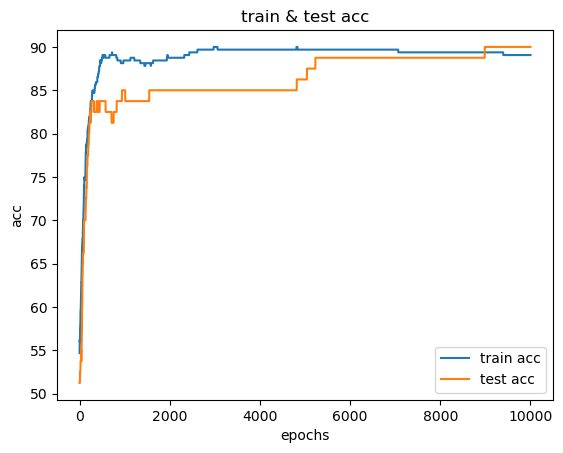

In [14]:
import matplotlib.pyplot as plt
plt.plot(range(0, epochs + 1), train_acc_hist, label="train acc")
plt.plot(range(0, epochs + 1), test_acc_hist, label="test acc")
plt.title("train & test acc")
plt.xlabel("epochs")
plt.ylabel("acc")
plt.legend()
plt.show()

In [15]:
model.state_dict()

OrderedDict([('linear_layer.weight',
              tensor([[-0.1825, -0.1211,  3.6460, -0.0998]], dtype=torch.float64)),
             ('linear_layer.bias', tensor([-1.8237], dtype=torch.float64))])

In [16]:
model.eval()
with torch.inference_mode():
  y_pred = model(x_test)
(torch.round(y_pred)==y_test).sum() / len(y_test) * 100

tensor(90.)

In [17]:
torch.save(obj=model.state_dict(), f='model/pytorch logistic regression')
model_2 = LogisticRegressionModel()
model_2.state_dict()

OrderedDict([('linear_layer.weight',
              tensor([[ 0.4788, -0.3164,  0.3259,  0.3002]], dtype=torch.float64)),
             ('linear_layer.bias', tensor([0.1951], dtype=torch.float64))])

In [18]:
model_2.load_state_dict(state_dict=torch.load(f='model/pytorch logistic regression'))
model_2.state_dict()

OrderedDict([('linear_layer.weight',
              tensor([[-0.1825, -0.1211,  3.6460, -0.0998]], dtype=torch.float64)),
             ('linear_layer.bias', tensor([-1.8237], dtype=torch.float64))])

### 測試步驟寫成函式

In [19]:
def train_step(model, cost_function, optimizer, x_train, y_train, train_cost_hist, train_acc_hist):
    model.train()

    y_pred = model(x_train)

    train_cost = cost_function(y_pred, y_train)
    train_cost_hist.append(train_cost.detach().numpy())

    train_acc = (torch.round(y_pred)==y_train).sum() / len(y_train) * 100
    #torch.round做四捨五入
    train_acc_hist.append(train_acc.detach().numpy())

    optimizer.zero_grad()
    train_cost.backward()
    optimizer.step()

    return train_acc


def test_step(model, cost_function, optimizer, x_test, y_test, test_cost_hist, test_acc_hist):
    model.eval()
    with torch.inference_mode():
        test_pred = model(x_test)
        test_cost = cost_function(test_pred, y_test)
        test_cost_hist.append(test_cost.numpy())

        test_acc = (torch.round(test_pred)==y_test).sum() / len(y_test) * 100
        test_acc_hist.append(test_acc.numpy())

    return test_acc

In [20]:
epochs = 10000

for epoch in range(epochs + 1):
    train_cost_hist = []
    test_cost_hist = []
    train_acc_hist = []
    test_acc_hist = []

    if epoch%1000==0:
        print(f"Epoch: {epoch:5}, Train acc: {train_step(model, cost_function, optimizer, x_train, y_train, train_cost_hist, train_acc_hist):7}%, Test acc: {test_step(model, cost_function, optimizer, x_test, y_test, test_cost_hist, test_acc_hist):5}%")

Epoch:     0, Train acc: 89.0625%, Test acc:  90.0%
Epoch:  1000, Train acc: 89.0625%, Test acc:  90.0%
Epoch:  2000, Train acc: 89.0625%, Test acc:  90.0%
Epoch:  3000, Train acc: 89.0625%, Test acc:  90.0%
Epoch:  4000, Train acc: 89.0625%, Test acc:  90.0%
Epoch:  5000, Train acc: 89.0625%, Test acc:  90.0%
Epoch:  6000, Train acc: 89.0625%, Test acc:  90.0%
Epoch:  7000, Train acc: 89.0625%, Test acc:  90.0%
Epoch:  8000, Train acc: 89.0625%, Test acc:  90.0%
Epoch:  9000, Train acc: 89.0625%, Test acc:  90.0%
Epoch: 10000, Train acc: 89.0625%, Test acc:  90.0%
